# Extracting Insights From Apple Inc.'s 2023 Form 10-K Report Using Retrieval-Augmented Generation (RAG)

#### Form 10-K
A Form 10-K is an annual report mandated by the U.S. Securities and Exchange Commission (SEC) that provides a detailed overview of a company's financial performance. It includes critical information such as company history, organizational structure, executive compensation, equity holdings, subsidiaries, and audited financial statements. These reports are extensive and complex, containing essential financial data, risk factors, and operational insights.

<br>

#### Extracting Insights From Apple Inc.'s 2023 Form 10-K Report Using RAG
Due to the density and complexity of these documents, we leverage RAG to extract insights from Apple Inc.'s 2023 Form 10-K report. RAG enhances the ability to generate meaningful responses by retrieving precise, up-to-date information directly from the report. This ensures accurate analysis while overcoming the typical limitations of standalone language models. By using RAG, users can ask detailed questions, receive context-specific insights, and make informed decisions based on the most current corporate filings.



# Summary

This notebook explores the limitations of Large Language Models (LLMs) and introduces RAG as a solution. The notebook covers practical steps for implementing RAG, including:

- **Installing Dependencies**: Setting up necessary libraries and tools.
- **Importing Libraries**: Loading required Python libraries.
- **Downloading Data**: Acquiring necessary datasets.
- **Preprocessing Text**: Cleaning and preparing text data.
- **Creating a Dataset**: Structuring data for use.
- **Creating Vector Database**: Building a database for information retrieval.
- **Querying from Vector Database**: Extracting relevant data based on queries.
- **Loading a Pre-trained Model for Language Generation**: Setting up the language model.
- **Asking Questions to the LLM**: Interacting with the model to generate responses.
- **Providing Knowledge to the LLM**: Enhancing the model’s knowledge base.
- **Comparing LLM and RAG Responses with the Ground Truth**: Evaluating the model’s answers against a reference report.

# Limitations of LLMs

LLMs are generative models composed of billions of parameters and trained on vast datasets. They excel at tasks like answering questions, translating languages, and completing sentences. However, despite their strength, LLMs have notable limitations, including:

- **Misinformation**: LLMs may present incorrect or fabricated information when they don't have a valid answer.
- **Outdated or Generic Information**: LLMs can deliver outdated or overly broad responses, especially when users expect up-to-date or specific answers.
- **Terminology Confusion**: LLMs might generate inaccurate responses due to differing interpretations of terminology across various training sources, leading to confusion.
- **Static Knowledge**: Since LLM training data is static, the models have a knowledge cut-off date, which limits their ability to provide recent information.


# Addressing LLM Limitations with RAG

RAG is a method designed to overcome some of these challenges by extending the capabilities of LLMs:
- Rather than relying solely on their training data, RAG allows LLMs to access external knowledge sources — such as domain-specific databases or an organization's internal knowledge base — without requiring the model to be retrained.

- In practice, RAG enhances the effectiveness of LLMs by directing them to retrieve relevant, up-to-date information from predefined knowledge sources. This process ensures that responses are more accurate and contextually relevant, as the model is able to reference fresh, domain-specific data before generating an output.

By combining the generative power of LLMs with the precision of targeted data retrieval, RAG significantly improves the accuracy and relevance of responses, addressing many of the inherent limitations of LLMs.



# Further Benefits of RAG

## Greater Control Over Generated Text Output

With RAG, developers can efficiently test and improve chat applications by adjusting the LLM's information sources to meet evolving requirements. They can control access to sensitive information, ensuring appropriate responses based on authorization levels. Developers can also troubleshoot and correct instances where the LLM references incorrect sources, enabling confident implementation of generative AI across various applications.

## Transparency in Response Generation

RAG enables the LLM to attribute information to specific sources, providing users with transparency. Users can access cited sources for further clarification, increasing trust and confidence in the AI's output.

## Access to Current Information

RAG ensures relevancy by allowing developers to connect the LLM to live data sources, such as social media feeds or news sites. This keeps the model's output up-to-date with the latest research, statistics, or news.

## Cost-Effective Implementation

Retraining LLMs for domain-specific needs is expensive. RAG offers a cost-effective alternative, allowing organizations to introduce new data without the need for full retraining.

# How RAG Works

- Without RAG, the LLM takes the user input and creates a response based on information it was trained on.

- With RAG, an information retrieval component is introduced that utilizes the user input (query) to first pull information from a new data source.

- The user query and the relevant information (context) are both given to the LLM.

- The LLM uses the new knowledge and its training data to create better responses. The following sections provide an overview of the process.

The following diagram shows the conceptual flow of using RAG with LLMs.

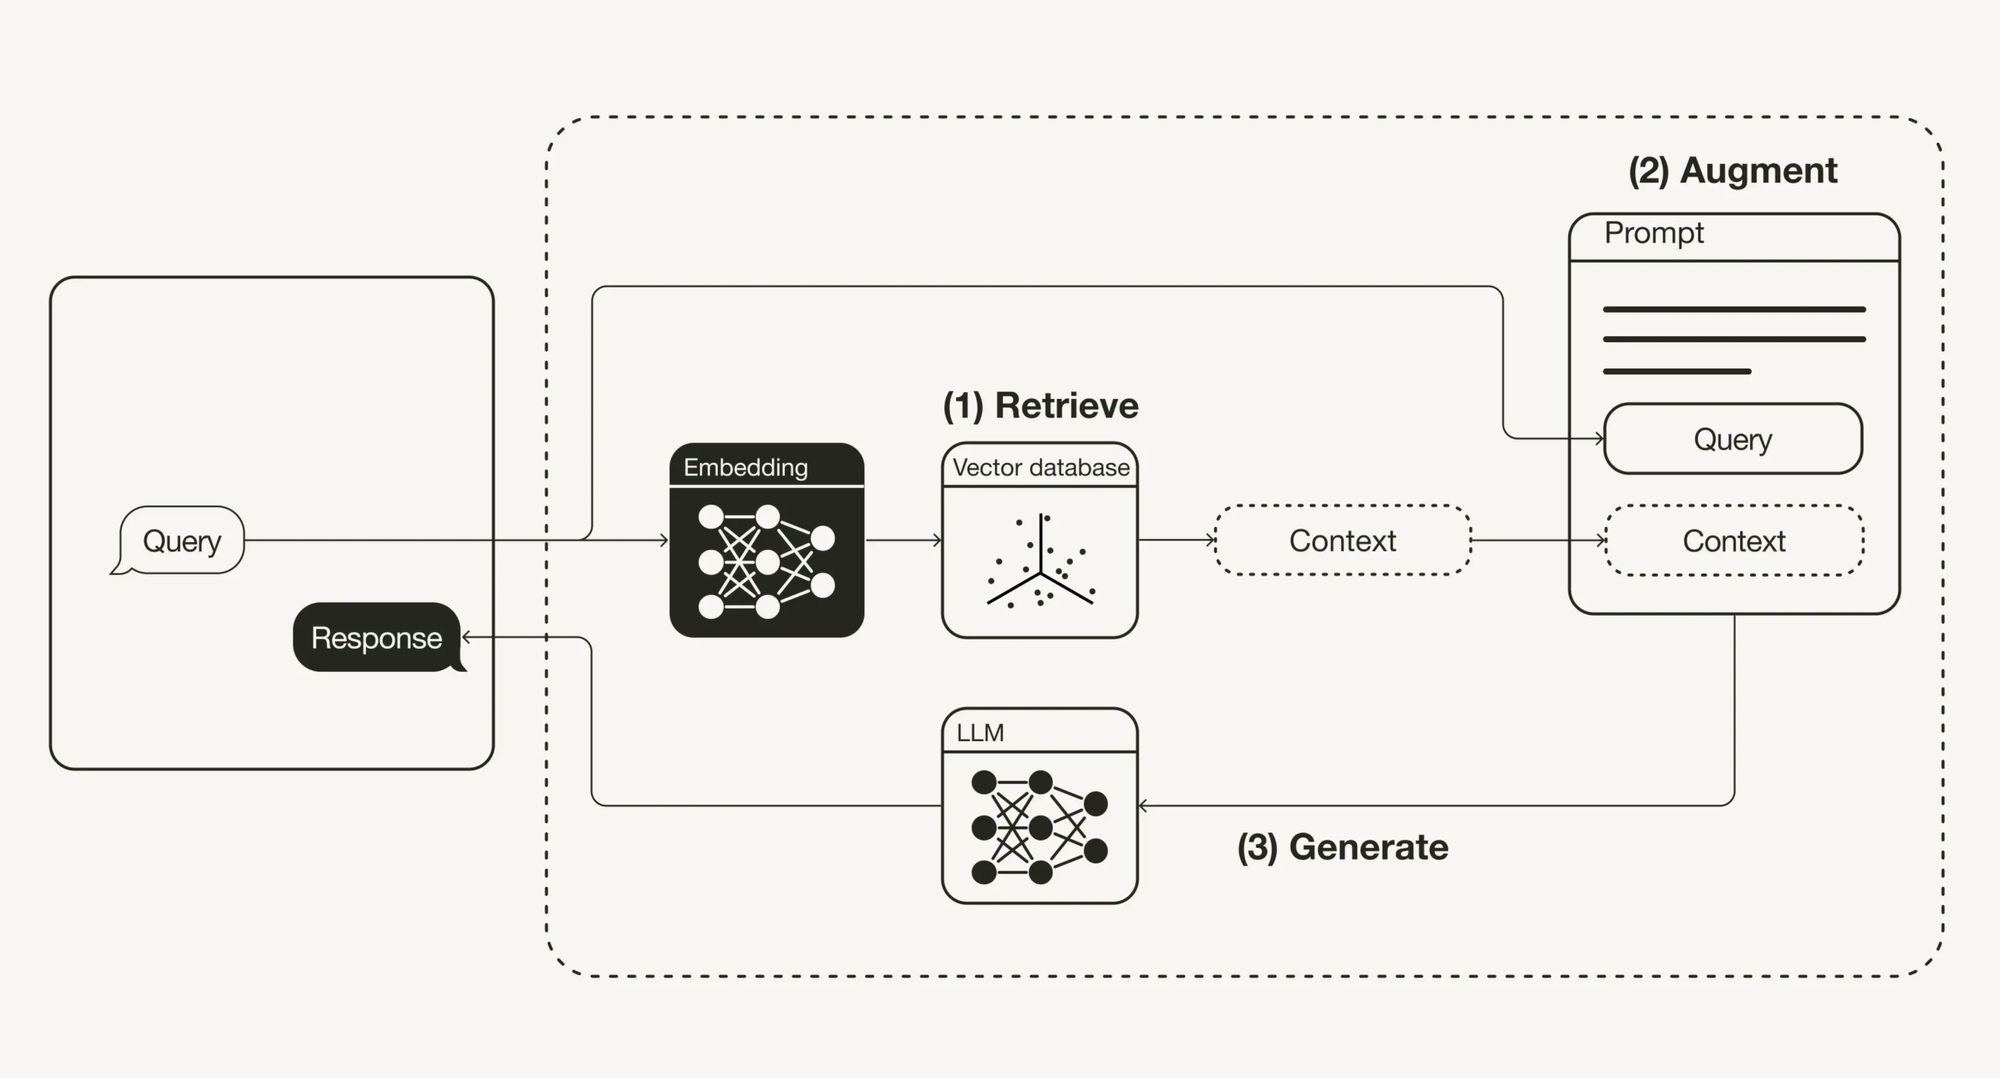

## Vector Database

- New data outside the LLM's original training set can come from various sources such as APIs, databases, or document repositories, in formats like files, records, or long-form text.
- Using **Embedding Models**, this data is converted into numerical representations and stored in a **vector database**. This process creates a knowledge library that generative AI models can efficiently reference and understand.

## Retrieval of Relevant Information

- When a user submits a query, the system performs a relevancy search by converting the query into a vector representation and matching it against a vector database.
- For example, in a chatbot handling financial and economic data for a company, if the query is "*How much was the company's Gross Margin in 2024?*", the system retrieves the relevant annual financial report. The document is selected based on its relevance, which is determined through mathematical vector calculations.

## Augmenting the LLM Prompt

- After retrieving the relevant data, an augmented prompt is created by integrating this information into the query. For example:

  ```
  def augment_prompt(query: str) -> str:
      context = get_relevant_info_from_vector_db(query, n_sources)
      
      augmented_prompt = f"""
      Use the context to answer the question.
      Context: {context}
      Question: {query}
      Answer:
      """

      return augmented_prompt

  ```

- This approach leverages prompt engineering techniques to ensure the LLM can effectively interpret the provided data. The augmented prompt helps the LLM generate a precise response based on both the user's query and the retrieved information.


## Updating External Data

A common challenge with external data is its potential to become outdated. To ensure information remains current, it is crucial to update documents and their vector representations. This can be accomplished through automated real-time updates or periodic batch processing. Keeping the data up-to-date ensures accurate retrieval and relevance for future queries.

# Implementation

# Installing Dependencies

In [1]:
!pip install -qU PyPDF2 chromadb

# Import libraries

In [2]:
# Import necessary libraries for web requests, PDF processing, data manipulation, text analysis, and machine learning
import requests
import PyPDF2
import os
import numpy as np
import re
import nltk
import time
import pandas as pd
import chromadb
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from textwrap import wrap
from tqdm import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from PyPDF2 import PdfReader

# Set random seed for reproducibility
torch.random.manual_seed(0)

# Download NLTK tokenizer models
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Download Data

Next, we will download the Apple Inc.'s 2023 Form 10-K Report.

In [3]:
def download_pdf(url, save_dir):
    # Download a PDF from a URL and save it locally.
    local_filename = os.path.join(save_dir, url.split("/")[-1])
    with requests.get(url, stream=True) as r: # Stream the request to handle large files
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): # Write the file in chunks
                f.write(chunk)
    return local_filename

def extract_text_from_pdf(pdf_path):
    # Extract text from each page of a PDF and return as a dictionary.
    reader = PdfReader(pdf_path)
    text = {}
    for i, page in enumerate(reader.pages, 1):
        text[i] = page.extract_text() or "" # Extract text or return empty string if none
    return text

In [4]:
# Define the directory to save the PDF and create it if it doesn't exist
save_dir = 'report_folder'
os.makedirs(save_dir, exist_ok=True)

# URL of the PDF to download
url = 'https://s2.q4cdn.com/470004039/files/doc_earnings/2023/q4/filing/_10-K-Q4-2023-As-Filed.pdf'

# Download the PDF to the specified directory
download_pdf(url, save_dir)

# Construct the path to the downloaded file
file_path = rf'/content/report_folder/{os.listdir(save_dir)[0]}'

# Preprocessing Text

Now, we need to preprocess the document.

1. First, we remove boilerplate legal text, such as sections on regulations and standard phrases like "Indicate by check mark," which do not add value to the analysis.
2. Next, we filter out non-informative elements, including page numbers, footers, phone numbers, and addresses, which are irrelevant to the content.
3. Then, we generate chunks out of the text, allowing for an 50-tokens overlap between chunks.
4. Finally, before preprocessing the text, we also filter it extracting only the data from Parts I to III of the document, as these sections contain the most relevant financial information about the company, including key insights into its operations, risks, and performance.

In [5]:
def remove_boilerplate(text):
    # Remove specific symbols and boilerplate text patterns
    text = re.sub(r"☒|☐|—|®|™", "", text)
    text = re.sub(r"Apple Inc. \| \d{4}  Form 10-K \| \d+[a-zA-Z]*", "", text, flags=re.IGNORECASE)
    return text

def normalize_text(text):
    # Convert text to lowercase, replace multiple spaces with a single space, and strip leading/trailing spaces
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text

def segment_text(text, max_chunk_length=500, overlap=50):
    # Split text into chunks with a specified max length and overlap between chunks
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []

    for sentence in sentences:
        sentence_tokens = word_tokenize(sentence) # Tokenize the current sentence
        current_chunk.extend(sentence_tokens)

        if len(current_chunk) >= max_chunk_length: # If current chunk length exceeds max_chunk_length
            chunks.append(' '.join(current_chunk[:max_chunk_length])) # Append the chunk (up to max_chunk_length)
            current_chunk = current_chunk[-overlap:] # Start the next chunk with an overlap of 100 tokens

    if current_chunk:
        chunks.append(' '.join(current_chunk)) # Add the last chunk if there's any leftover text

    return chunks

def preprocess(text):
    # Apply all preprocessing steps: remove boilerplate, normalize text, and segment into chunks
    text = remove_boilerplate(text)
    text = normalize_text(text)
    text = segment_text(text)
    return text

In [6]:
# Extract text from the specified PDF file
text = extract_text_from_pdf(file_path)

# Remove header 'PART I' from the beginning of page 4 text
text[4] = text[4].split('PART I')[-1]

# Remove everything after 'PART III' from page 56 text
text[56] = text[56].split('PART III')[0]

# Filter text from pages 4 to 56 (adjusted by subtracting 3 to match document pages)
filtered_text = {page - 3: page_text for page, page_text in text.items() if page > 3 and page < 57}

# Preprocess the filtered text (remove boilerplate, normalize, and segment)
preprocessed_text = {page: preprocess(page_text) for page, page_text in filtered_text.items()}

In [7]:
preprocessed_text[1]

['item 1. business company background the company designs , manufactures and markets smartphones , personal computers , tablets , wearables and accessories , and sells a variety of related services . the company ’ s fiscal year is the 52- or 53-week period that ends on the last saturday of september . products iphone iphone is the company ’ s line of smartphones based on its ios operating system . the iphone line includes iphone 15 pro , iphone 15 , iphone 14 , iphone 13 and iphone se . mac mac is the company ’ s line of personal computers based on its macos operating system . the mac line includes laptops macbook air and macbook pro , as well as desktops imac , mac mini , mac studio and mac pro . ipad ipad is the company ’ s line of multipurpose tablets based on its ipados operating system . the ipad line includes ipad pro , ipad air , ipad and ipad mini . wearables , home and accessories wearables includes smartwatches and wireless headphones . the company ’ s line of smartwatches , 

# Create a Dataset

Now, we create a dataset with an ID for each chunk.

In [8]:
# Initialize an empty list to store chunk data
chunks_list = []

# Iterate over the preprocessed text for each page
for page, chunks in preprocessed_text.items():
    for i, chunk in enumerate(chunks):
        # Append page number, chunk number, a unique id, and the chunk text to the list
        chunks_list.append([page, i + 1, f'page_{page}_{i + 1}', chunks[i]])

# Convert the list into a DataFrame with columns for page, chunk number, id, and chunk text
dataset = pd.DataFrame(chunks_list, columns=['page', 'chunk', 'id', 'chunk_text'])

In [30]:
dataset.head()

,page,chunk,id,chunk_text
0,1,1,page_1_1,item 1. business company background the compan...
1,2,1,page_2_1,services advertising the company ’ s advertisi...
2,2,2,page_2_2,"pressure on gross margins , frequent introduct..."
3,3,1,page_3_1,the company ’ s ability to compete successfull...
4,3,2,page_3_2,components customized to meet the company ’ s ...


# Create a Vector Database

We will use ChromaDB to create the vector database.

- **ChromaDB** is a simple, open-source solution designed for efficient retrieval of embeddings and document indexing. ChromaDB seamlessly integrates with modern machine learning workflows, offers high performance, and is well-suited for small to medium-scale applications. It allows for easy scaling and real-time updates, making it a good choice for managing document vectors in retrieval-augmented generation tasks.

Alternatively, we could also use **Pinecone** or **FAISS**.

- **Pinecone** is a managed, cloud-based vector database designed for large-scale machine learning applications. ChromaDB is indicated because of its scalability and performance, offering features like distributed indexing and search, which makes it ideal for production environments that require handling massive datasets and low-latency queries.

- **FAISS** (Facebook AI Similarity Search) is an open-source library specifically developed for efficient similarity search and clustering of dense vectors. It is optimized for speed and memory efficiency, particularly when dealing with large datasets. FAISS is a popular choice when working on large-scale, high-performance vector search tasks but requires more setup and maintenance than ChromaDB or Pinecone.

## Embedding Model
For simplicity, we use ChromaDB's default embedding model [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), a lightweight transformer-based model from Hugging Face that maps sentences and paragraphs to a 384 dimensional vector space and can be used for tasks like clustering or semantic search. [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) is well-suited for general-purpose text embeddings, especially for tasks with limited computational resources or where scalability is a priority.  

[ChromaDB also supports other Hugging Face embedding models](https://parkeunsang.github.io/blog/python/2023/12/20/chroma-db-change-embeddingsuse-huggingface-model.html), and switching models is straightforward via its integration. You may want to change the embedding model if you need embeddings tailored to specific domains (e.g., finance, law, or biomedicine) or if your application requires embeddings with higher semantic richness or longer context windows, yielding more accurate embeddings, particularly for complex or nuanced text. However, this will most probably increase the computational overhead in terms of both inference time and memory usage.



In [9]:
# Initialize a ChromaDB client
client = chromadb.Client()

# Create a new collection in ChromaDB named "all-my-documents"
collection = client.create_collection("all-my-documents")

In [10]:
# Add documents and their unique IDs to the ChromaDB collection
collection.add(
    documents=dataset.chunk_text.values.tolist(),  # List of text chunks to be added as documents
    ids=dataset.id.values.tolist(),  # List of unique IDs corresponding to each document
)

# Query from the Vector Database

In [11]:
def get_context(query: str, n_sources=3) -> (list):
    # Query the ChromaDB collection to retrieve the top `n_sources` documents matching the query
    results = collection.query(
        query_texts=[query],  # Query text
        n_results=n_sources  # Number of results to return
    )

    ids = results['ids'][0]  # Extract document IDs
    documents = results['documents'][0]  # Extract document texts
    documents = "\n".join(documents)

    return ids, documents  # Return IDs and corresponding documents

In [12]:
# Retrieve the top 3 documents related to the query about Apple's Gross Margin
question = """Give me insights about Apple's Gross Margin."""
get_context(question, n_sources=3)

(['page_28_1', 'page_31_1', 'page_30_1'],
 'apple inc. consolidated statements of operations ( in millions , except number of shares , which are reflected in thousands , and per-share amounts ) years ended september 30 , 2023september 24 , 2022september 25 , 2021 net sales : products $ 298,085 $ 316,199 $ 297,392 services 85,200 78,129 68,425 total net sales 383,285 394,328 365,817 cost of sales : products 189,282 201,471 192,266 services 24,855 22,075 20,715 total cost of sales 214,137 223,546 212,981 gross margin 169,148 170,782 152,836 operating expenses : research and development 29,915 26,251 21,914 selling , general and administrative 24,932 25,094 21,973 total operating expenses 54,847 51,345 43,887 operating income 114,301 119,437 108,949 other income/ ( expense ) , net ( 565 ) ( 334 ) 258 income before provision for income taxes 113,736 119,103 109,207 provision for income taxes 16,741 19,300 14,527 net income $ 96,995 $ 99,803 $ 94,680 earnings per share : basic $ 6.16 $ 6.15

# Load a Pre-trained Model for Language Generation

In [13]:
# Load the pre-trained model and tokenizer for language generation
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",  # Use GPU for computation
    torch_dtype="auto",
    trust_remote_code=True,
)

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**Important remark concerning the generation arguments:**


- Greedy Decoding selects word with the highest probability at each step. Some of its characteristics are:
  - Deterministic: The output is predictable and consistent for a given input.
  - Speed: Often faster since it involves a straightforward, single-step decision.
  - Potential Issue: Can lead to repetitive or less diverse text as it always picks the most probable next word.
- Sampling approach selects the next word based on a probability distribution, which involves randomness. Some of its characteristics are:
  - Stochastic: The output can vary each time you generate text for the same input.
  - Diversity: Can produce more diverse and creative outputs as it samples from a range of possible next words.
  - Flexibility: Parameters like temperature and top-k or top-p sampling can be used to control the diversity and creativity of the generated text.

In [14]:
# Initialize a text generation pipeline with the pre-trained model and tokenizer
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer
)

# Asking Questions to the LLM

Let's test the knowledge of the LLM by asking it specific questions about Apple's gross margin in 2023 (which it probably does not know about).

In [15]:
def get_response(query: str, max_new_tokens=500):
    # Set arguments for text generation
    generation_args = {
        "max_new_tokens": max_new_tokens,  # Maximum number of new tokens to generate
        "return_full_text": False,  # Return only generated text, not the full input
        "do_sample": False,  # Use greedy decoding (no sampling)
    }

    # Record the start time for performance measurement
    tick = time.time()

    # Define the conversation history for context
    messages = [
        {"role": "system", "content": "You are a helpful AI assistant specialized in Finance and Apple Inc."},
        {"role": "user", "content": "How much was Apple's total net sales?"},
        {"role": "assistant", "content": "The Company’s total net sales were $383.3 billion and net income was $97.0 billion during 2023."},
        {"role": "user", "content": query},
    ]

    # Generate a response using the text generation pipeline and the arguments we pre-defined
    output = pipe(messages, **generation_args)
    output = output[0]['generated_text']

    # Print the time taken to generate the response
    print(f"Time to generate the response: {round(time.time() - tick, 1)}s")

    return output

In [27]:
response = get_response(question)
print('\n'*2, response)

Time to generate the response: 5.9s


  Apple's gross margin for the fiscal year 2023 was 38.6%. This means that for every dollar of revenue, Apple retained 38.6 cents after accounting for the cost of goods sold (COGS). This high gross margin indicates that Apple has a strong control over its production costs and pricing strategy. The company's ability to maintain a high gross margin is a testament to its efficient supply chain management, economies of scale, and premium pricing strategy.


# Providing External Knowledge to the LLM

Now, we will allow the LLM to access external knowledge sources. Specifically, we will provide the LLM with knowledge taken from our domain-specific vector database composed of information taken from Apple Inc.'s 2023 Form 10-K Report.

In [17]:
def generate_prompt(query: str, n_sources):
    # Retrieve relevant sources and context for the given query
    sources, context = get_context(query, n_sources)

    # Format the prompt with context and question
    prompt = f"""Use the context to answer the question.

    Context: {context}
    Question: {query}
    Answer:
    """

    return prompt, sources  # Return the formatted prompt and source IDs

In [22]:
def get_response_RAG(query: str,
                     max_new_tokens=500,
                     n_sources=3,
                     show_sources=True):

    # Set arguments for text generation
    generation_args = {
        "max_new_tokens": max_new_tokens,  # Maximum number of new tokens to generate
        "return_full_text": False,  # Return only generated text, not the full input
        "do_sample": False,  # Use greedy decoding (no sampling)
    }

    # Record the start time for performance measurement
    tick = time.time()

    # Generate the prompt and retrieve relevant sources
    prompt, sources = generate_prompt(query, n_sources)

    # Define the conversation history for context
    messages = [
        {"role": "system", "content": "You are a helpful AI assistant specialized in Finance and Apple Inc."},
        {"role": "user", "content": "How much was Apple's total net sales?"},
        {"role": "assistant", "content": "The Company’s total net sales were $383.3 billion and net income was $97.0 billion during 2023."},
        {"role": "user", "content": prompt},
    ]

    # Generate a response using the text generation pipeline and the arguments we pre-defined
    output = pipe(messages, **generation_args)
    output = output[0]['generated_text']

    # Print the time taken to generate the response
    print(f"Time to generate the response: {round(time.time() - tick, 1)}s")

    # Optionally include sources in the output
    if show_sources:
        sources = [" ".join(source.split("_")[:-1]).capitalize() for source in sources]
        sources = "\n\nSources: \n" + "\n".join(sources)
        return output + sources
    else:
        return output

# Asking Questions to the RAG Model

In [29]:
response = get_response_RAG(question, max_new_tokens=800, n_sources=4, show_sources=True)
print('\n'*2, response)

Time to generate the response: 58.1s


  Apple Inc.'s gross margin for the years 2023, 2022, and 2021 were as follows:

- Products gross margin:
  - 2023: $108,803 million
  - 2022: $114,728 million
  - 2021: $105,126 million

- Services gross margin:
  - 2023: $60,345 million
  - 2022: $56,054 million
  - 2021: $47,710 million

- Total gross margin:
  - 2023: $169,148 million
  - 2022: $170,782 million
  - 2021: $152,836 million

- Gross margin percentage:
  - Products:
    - 2023: 36.5%
    - 2022: 36.3%
    - 2021: 35.3%
  - Services:
    - 2023: 70.8%
    - 2022: 71.7%
    - 2021: 69.7%
  - Total:
    - 2023: 44.1%
    - 2022: 43.3%
    - 2021: 41.8%

Insights about Apple's Gross Margin:

1. The gross margin for products decreased in 2023 compared to 2022 due to the weakness in foreign currencies relative to the U.S. dollar and lower product volume. However, this was partially offset by cost savings and a different product mix.

2. The gross margin percentage for products increased

# Compare Responses with Ground-Truth (Target)

Let's us assess the responses generated by the original LLM and the RAG model. Figure 1 and 2 provide the ground truth to answer our question.

In [31]:
question

"Give me insights about Apple's Gross Margin."

## Figure 1

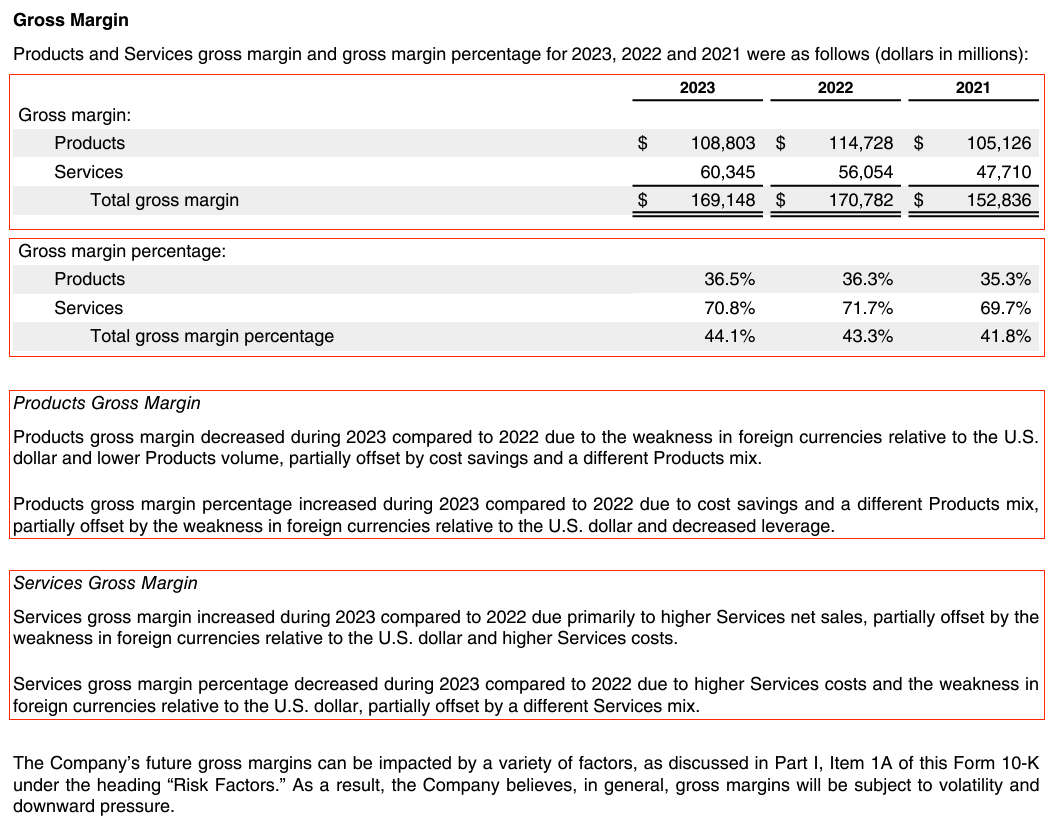

## Figure 2

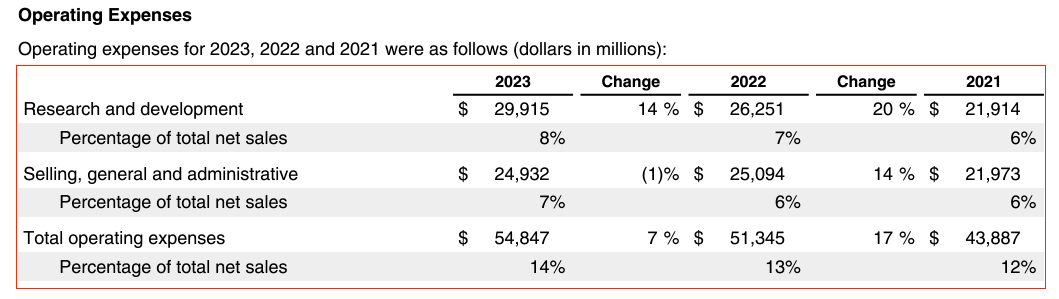

## Assessing the Response Generated Without RAG
- False information: *Apple's gross margin for the fiscal year 2023 was **38.6**%* - See Figure 1;
- All other content is too general and does not address the question.

## Assessing the Response Generated With RAG
- The generated response answers the question;
- The numbers are correct - See Figure 1;
- Insights 1, 2, 3, 4, and 5 are correct - See Figure 1;
- Insights 6 and 7 are also correct- See Figure 2;
- The content is not general but instead, specific about Apple Inc Gross Margin.

# Conclusion
The response generated without RAG provided false information and was overly general, failing to address the specific question. In contrast, the response generated with RAG accurately answered the question, providing correct numbers and detailed, specific insights about Apple's gross margin. The RAG-based approach proved to be more reliable and precise, as confirmed by Figures 1 and 2.

# References
[Form 10-K](https://en.wikipedia.org/wiki/Form_10-K)

[What is RAG (Retrieval-Augmented Generation)?](https://aws.amazon.com/what-is/retrieval-augmented-generation/?nc1=h_ls)

[Retrieval Augmented Generation Reduce Hallucinations - Enterprise AI](https://blog-ko.allganize.ai/retrieval-augmented-generation-rag-reduce-hallucinations-enterprise-ai/)